# ECG 4-Classes Classification (PyTorch) — Version Améliorée avec Cross-Validation

Ce notebook contient **toutes les améliorations** recommandées pour l'entraînement d'un modèle CNN à 4 classes sur des images ECG.

## Améliorations incluses :

1. ✅ **Augmentation de données adaptée aux ECG** (sans rotation/flip)
2. ✅ **Régularisation** (Dropout + Weight Decay)
3. ✅ **Early Stopping** (arrêt automatique)
4. ✅ **API PyTorch moderne** (torch.amp au lieu de torch.cuda.amp)
5. ✅ **Analyse des erreurs** (visualisation des images mal classées)
6. ✅ **Validation Croisée K-Fold dès le début** (entraînement robuste avec 5 folds)

## Structure du dataset :
```
processed_dataset_4_classes/
  Normal/
  Myocardial_Infarction/
  Abnormal_Heartbeat/
  History_MI/
```


## 0) Setup & Configuration


In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report
)
import random

SEED     = 42
IMG_SIZE = 224
BATCH    = 64
ROOT     = "../processed_dataset_4_classes"  # Dataset avec 4 classes

# Reproducibility & GPU
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False


Device: cuda


## 1) Calcul de la moyenne et de l'écart-type (pour normalisation)


In [4]:
# Vérifier que le dossier existe
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"Le dossier '{ROOT}' n'existe pas. Vérifiez le chemin.")

# Temporary transform to compute mean/std (no Normalize yet)
tx_tmp = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),           # -> [0,1]
])

ds_tmp = datasets.ImageFolder(ROOT, transform=tx_tmp)
print(f"Dataset trouvé: {len(ds_tmp)} images dans {len(ds_tmp.classes)} classes")
print(f"Classes: {ds_tmp.classes}")
loader_tmp = DataLoader(ds_tmp, batch_size=128, num_workers=min(8, os.cpu_count() or 1), shuffle=False)

psum = 0.0
psum_sq = 0.0
count = 0

for x, _ in loader_tmp:
    b = x.size(0)        # [B,1,H,W]
    x = x.view(b, -1)
    psum    += x.sum()
    psum_sq += (x**2).sum()
    count   += x.numel()

mean = (psum / count).item()
std  = ((psum_sq / count - mean**2) ** 0.5).item()
print(f"mean={mean:.6f}, std={std:.6f}")


Dataset trouvé: 928 images dans 4 classes
Classes: ['Abnormal_Heartbeat', 'History_MI', 'Myocardial_Infarction', 'Normal']
mean=0.450137, std=0.175183


## 2) Dataset avec augmentation de données adaptée aux ECG

### ⚠️ Augmentation de données pour ECG

**Transformations à ÉVITER pour les images ECG :**
- ❌ **Rotation** : Détruit l'axe temporel (critique pour l'interprétation médicale)
- ❌ **Flip horizontal** : Inverse le sens temporel
- ❌ **Flip vertical** : Change la signification des ondes (P, QRS, T)

**Transformations RECOMMANDÉES :**
- ✅ **Translation verticale légère** : Simule variation de baseline
- ✅ **Variation contraste/luminosité** : Simule conditions d'acquisition différentes
- ✅ **Bruit gaussien léger** : Simule artefacts de mesure


In [5]:
MEAN, STD = mean, std

# Classe pour ajouter du bruit gaussien (peut être picklée pour multiprocessing)
class AddGaussianNoise:
    """Ajoute un bruit gaussien léger à l'image (simule artefacts de mesure)"""
    def __init__(self, std=0.01):
        self.std = std
    
    def __call__(self, x):
        return torch.clamp(x + torch.randn_like(x) * self.std, 0, 1)

# Transformations pour validation/test (sans augmentation)
tx_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                 # -> [0,1]
    transforms.Normalize([MEAN], [STD]),   # normalization
])

# Transformations pour training (AVEC augmentation adaptée aux ECG)
# IMPORTANT: Pour les ECG, on évite rotation/flip qui détruisent la signification médicale
tx_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Augmentations adaptées aux ECG:
    # - Translation verticale légère (simule variation de baseline)
    transforms.RandomAffine(degrees=0, translate=(0, 0.05), fill=0),
    # - Variation de contraste/luminosité (simule conditions d'acquisition)
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                 # -> [0,1]
    # - Ajout de bruit gaussien léger (simule artefacts de mesure)
    # Utilise une classe au lieu d'une lambda (picklable pour multiprocessing)
    AddGaussianNoise(std=0.01),
    transforms.Normalize([MEAN], [STD]),   # normalization
])

# Charger dataset avec transformations de base pour le split
ds_tmp = datasets.ImageFolder(ROOT, transform=tx_val)
print(f"Dataset chargé: {len(ds_tmp)} images")
print(f"Classes: {ds_tmp.classes}")
y  = np.array(ds_tmp.targets)
idx = np.arange(len(ds_tmp))

# Séparer un petit test set final (10%) pour l'évaluation finale
# Le reste (90%) sera utilisé pour la cross-validation
idx_cv, idx_te, y_cv, y_te = train_test_split(
    idx, y, test_size=0.10, random_state=SEED, stratify=y
)

print(f"Données pour cross-validation: {len(idx_cv)} images")
print(f"Test set final: {len(idx_te)} images")

# Sur Windows, réduire num_workers et désactiver persistent_workers pour éviter les problèmes
# de multiprocessing. Sur Linux/Mac, vous pouvez augmenter num_workers.
import platform
is_windows = platform.system() == 'Windows'
num_workers = 0 if is_windows else min(4, os.cpu_count() or 1)  # 0 sur Windows, max 4 ailleurs
pin = (device.type == "cuda")
# Désactiver persistent_workers pour éviter les problèmes de pickling
use_persistent_workers = False

# Créer le test set final
test_ds = datasets.ImageFolder(ROOT, transform=tx_val)
test_set = Subset(test_ds, idx_te)
test_loader = DataLoader(test_set, batch_size=BATCH, shuffle=False,
                         num_workers=num_workers, pin_memory=pin, 
                         persistent_workers=use_persistent_workers)

print("Classes:", ds_tmp.classes, ds_tmp.class_to_idx)


Dataset chargé: 928 images
Classes: ['Abnormal_Heartbeat', 'History_MI', 'Myocardial_Infarction', 'Normal']
Données pour cross-validation: 835 images
Test set final: 93 images
Classes: ['Abnormal_Heartbeat', 'History_MI', 'Myocardial_Infarction', 'Normal'] {'Abnormal_Heartbeat': 0, 'History_MI': 1, 'Myocardial_Infarction': 2, 'Normal': 3}


In [6]:
import torch.nn as nn

NUM_CLASSES = len(ds_tmp.classes)  # 4 classes

class SimpleECGCNN(nn.Module):
    def __init__(self, img_size=IMG_SIZE, num_classes=NUM_CLASSES, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 112x112
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 28x28
            nn.Flatten(),
            nn.Dropout(dropout_rate),  # Régularisation pour réduire l'overfitting
            nn.Linear(64 * (img_size//8) * (img_size//8), num_classes)     # 4 logits pour 4 classes
        )
    def forward(self, x):
        return self.net(x)

model = SimpleECGCNN(num_classes=NUM_CLASSES, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()  # Pour classification multi-classe
# Ajout de weight decay pour la régularisation L2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning-rate scheduler (sans verbose pour éviter les warnings)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=False)

print(f"Modèle créé avec {NUM_CLASSES} classes: {ds_tmp.classes}")


Modèle créé avec 4 classes: ['Abnormal_Heartbeat', 'History_MI', 'Myocardial_Infarction', 'Normal']


C:\Users\ilias\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 4) Entraînement avec Cross-Validation K-Fold, Early Stopping et API PyTorch moderne

**Améliorations apportées :**
- ✅ **Validation Croisée K-Fold** : Entraînement robuste avec 5 folds dès le début
- ✅ **API PyTorch moderne** : `torch.amp` au lieu de `torch.cuda.amp` (évite les warnings)
- ✅ **Early Stopping** : Arrêt automatique si pas d'amélioration pendant 10 epochs
- ✅ **Meilleur suivi** : Affichage du learning rate actuel et résultats par fold


In [7]:
# Utiliser l'API moderne torch.amp (évite les warnings)
from torch.amp import autocast, GradScaler
import time

# Configuration de la validation croisée
K_FOLDS = 5  # Nombre de folds (5-fold cross-validation)
EPOCHS = 250
PATIENCE = 10  # Early stopping: arrêter si pas d'amélioration pendant 10 epochs

print(f"🔬 Démarrage de l'entraînement avec validation croisée {K_FOLDS}-fold...")
print(f"   Dataset pour CV: {len(idx_cv)} images")
print(f"   Test set final: {len(idx_te)} images")
print(f"   Chaque fold: ~{len(idx_cv)//K_FOLDS} images pour validation\n")

# Préparer les indices et labels pour la validation croisée
cv_indices = idx_cv
cv_labels = y_cv

# Stratified K-Fold pour maintenir la distribution des classes
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

def epoch_pass(model, loader, device, optimizer=None, criterion=None):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n_samples  = 0
    n_correct  = 0

    use_amp = (device.type == "cuda")
    dtype = torch.float16 if use_amp else torch.float32

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)  # [B] - labels de classe
        bs = xb.size(0)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            # API moderne torch.amp
            if use_amp:
                with autocast(device_type='cuda', dtype=dtype):
                    logits = model(xb)                 # [B, num_classes]
                    loss   = criterion(logits, yb)     # CrossEntropyLoss
            else:
                logits = model(xb)
                loss   = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Mode évaluation
            if use_amp:
                with torch.no_grad(), autocast(device_type='cuda', dtype=dtype):
                    logits = model(xb)
                    loss   = criterion(logits, yb)
            else:
                with torch.no_grad():
                    logits = model(xb)
                    loss   = criterion(logits, yb)

        # Accuracy pour classification multi-classe
        preds = logits.argmax(dim=1)  # [B]
        n_correct  += (preds == yb).sum().item()
        n_samples  += bs
        total_loss += loss.item() * bs

    mean_loss = total_loss / max(1, n_samples)
    acc = n_correct / max(1, n_samples)
    return mean_loss, acc

# Stocker les résultats de tous les folds
all_fold_histories = []
cv_results = {
    'fold': [],
    'best_val_loss': [],
    'best_val_acc': [],
    'best_epoch': [],
    'train_size': [],
    'val_size': []
}

# Stocker le meilleur modèle global (meilleure validation loss moyenne)
best_global_model = None
best_global_val_loss = float('inf')

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(cv_indices, cv_labels), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}/{K_FOLDS}")
    print(f"{'='*60}")
    print(f"Train: {len(train_idx)} images | Val: {len(val_idx)} images")
    
    # Créer les datasets pour ce fold
    train_fold_ds = datasets.ImageFolder(ROOT, transform=tx_train)
    val_fold_ds = datasets.ImageFolder(ROOT, transform=tx_val)
    
    # Utiliser les indices relatifs au dataset CV
    train_fold_indices = [cv_indices[i] for i in train_idx]
    val_fold_indices = [cv_indices[i] for i in val_idx]
    
    train_fold_set = Subset(train_fold_ds, train_fold_indices)
    val_fold_set = Subset(val_fold_ds, val_fold_indices)
    
    # Créer les loaders
    train_fold_loader = DataLoader(train_fold_set, batch_size=BATCH, shuffle=True,
                                   num_workers=num_workers, pin_memory=pin, 
                                   persistent_workers=use_persistent_workers)
    val_fold_loader = DataLoader(val_fold_set, batch_size=BATCH, shuffle=False,
                                num_workers=num_workers, pin_memory=pin, 
                                persistent_workers=use_persistent_workers)
    
    # Créer un nouveau modèle pour ce fold
    fold_model = SimpleECGCNN(num_classes=NUM_CLASSES, dropout_rate=0.3).to(device)
    fold_criterion = nn.CrossEntropyLoss()
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=1e-3, weight_decay=1e-4)
    fold_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        fold_optimizer, mode='min', factor=0.5, patience=2, verbose=False
    )
    scaler = GradScaler('cuda' if device.type == "cuda" else 'cpu', enabled=(device.type == "cuda"))
    
    # Historique pour ce fold
    fold_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    best_val = float('inf')
    best_state = None
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = epoch_pass(fold_model, train_fold_loader, device, 
                                     optimizer=fold_optimizer, criterion=fold_criterion)
        va_loss, va_acc = epoch_pass(fold_model, val_fold_loader, device, 
                                     optimizer=None, criterion=fold_criterion)
        
        fold_history["train_loss"].append(tr_loss)
        fold_history["val_loss"].append(va_loss)
        fold_history["train_acc"].append(tr_acc)
        fold_history["val_acc"].append(va_acc)
        
        fold_scheduler.step(va_loss)
        current_lr = fold_optimizer.param_groups[0]['lr']
        
        if epoch % 10 == 0 or epoch == 1:  # Afficher tous les 10 epochs
            print(f"  [{epoch:03d}/{EPOCHS}] "
                  f"train_loss={tr_loss:.4f} train_acc={tr_acc*100:.2f}% "
                  f"val_loss={va_loss:.4f}   val_acc={va_acc*100:.2f}% "
                  f"lr={current_lr:.6f}")
        
        # Early stopping
        if va_loss < best_val:
            best_val = va_loss
            patience_counter = 0
            best_state = {
                "epoch": epoch,
                "model": fold_model.state_dict(),
                "val_loss": va_loss,
                "val_acc": va_acc
            }
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"  ⚠️ Early stopping déclenché après {PATIENCE} epochs sans amélioration")
                break
    
    elapsed_time = time.time() - start_time
    
    # Charger le meilleur modèle de ce fold
    if best_state is not None:
        fold_model.load_state_dict(best_state["model"])
    
    # Sauvegarder les résultats
    all_fold_histories.append(fold_history)
    cv_results['fold'].append(fold_idx)
    cv_results['best_val_loss'].append(best_state['val_loss'] if best_state else va_loss)
    cv_results['best_val_acc'].append(best_state['val_acc'] if best_state else va_acc)
    cv_results['best_epoch'].append(best_state['epoch'] if best_state else epoch)
    cv_results['train_size'].append(len(train_fold_indices))
    cv_results['val_size'].append(len(val_fold_indices))
    
    # Mettre à jour le meilleur modèle global (basé sur la validation loss)
    if best_state and best_state['val_loss'] < best_global_val_loss:
        best_global_val_loss = best_state['val_loss']
        best_global_model = fold_model.state_dict()
    
    print(f"✅ Fold {fold_idx} terminé en {elapsed_time:.1f}s")
    print(f"   Best Val Loss: {best_state['val_loss']:.4f} | Best Val Acc: {best_state['val_acc']*100:.2f}% (epoch {best_state['epoch']})")

# Résumé des résultats
print(f"\n{'='*60}")
print("📊 RÉSULTATS DE LA VALIDATION CROISÉE")
print(f"{'='*60}")
print(f"\nMétriques moyennes sur {K_FOLDS} folds:")
print(f"  Val Loss: {np.mean(cv_results['best_val_loss']):.4f} ± {np.std(cv_results['best_val_loss']):.4f}")
print(f"  Val Acc:  {np.mean(cv_results['best_val_acc'])*100:.2f}% ± {np.std(cv_results['best_val_acc'])*100:.2f}%")
print(f"\nDétails par fold:")
for i in range(K_FOLDS):
    print(f"  Fold {cv_results['fold'][i]}: Loss={cv_results['best_val_loss'][i]:.4f}, "
          f"Acc={cv_results['best_val_acc'][i]*100:.2f}%, "
          f"Epoch={cv_results['best_epoch'][i]}")

# Sauvegarder le meilleur modèle global
if best_global_model is not None:
    os.makedirs("checkpoints", exist_ok=True)
    best_checkpoint = {
        "model": best_global_model,
        "num_classes": NUM_CLASSES,
        "class_names": ds_tmp.classes,
        "cv_mean_val_loss": np.mean(cv_results['best_val_loss']),
        "cv_mean_val_acc": np.mean(cv_results['best_val_acc']),
        "cv_std_val_loss": np.std(cv_results['best_val_loss']),
        "cv_std_val_acc": np.std(cv_results['best_val_acc']),
        "cv_results": cv_results
    }
    torch.save(best_checkpoint, "checkpoints/best_cnn_4_classes.pt")
    print(f"\n✅ Meilleur modèle sauvegardé (val_loss: {best_global_val_loss:.4f})")
    print("Checkpoint sauvegardé: checkpoints/best_cnn_4_classes.pt")
    
    # Charger le meilleur modèle dans le modèle principal pour l'évaluation
    model.load_state_dict(best_global_model)
else:
    print("\n⚠️ Attention: Aucun modèle n'a été sauvegardé")

# Créer un historique agrégé pour la visualisation (moyenne sur tous les folds)
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

# Calculer la moyenne des historiques de tous les folds
max_epochs = max(len(h["train_loss"]) for h in all_fold_histories)
for epoch in range(max_epochs):
    train_losses = [h["train_loss"][epoch] for h in all_fold_histories if epoch < len(h["train_loss"])]
    val_losses = [h["val_loss"][epoch] for h in all_fold_histories if epoch < len(h["val_loss"])]
    train_accs = [h["train_acc"][epoch] for h in all_fold_histories if epoch < len(h["train_acc"])]
    val_accs = [h["val_acc"][epoch] for h in all_fold_histories if epoch < len(h["val_acc"])]
    
    if train_losses:
        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(np.mean(val_losses))
        history["train_acc"].append(np.mean(train_accs))
        history["val_acc"].append(np.mean(val_accs))


🔬 Démarrage de l'entraînement avec validation croisée 5-fold...
   Dataset pour CV: 835 images
   Test set final: 93 images
   Chaque fold: ~167 images pour validation


Fold 1/5
Train: 668 images | Val: 167 images


C:\Users\ilias\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  [001/250] train_loss=1.9365 train_acc=20.81% val_loss=1.3739   val_acc=25.15% lr=0.001000
  [010/250] train_loss=1.1238 train_acc=54.79% val_loss=1.0994   val_acc=48.50% lr=0.001000
  [020/250] train_loss=0.5318 train_acc=81.44% val_loss=0.5884   val_acc=80.24% lr=0.001000
  [030/250] train_loss=0.3255 train_acc=89.82% val_loss=0.5184   val_acc=85.03% lr=0.001000
  [040/250] train_loss=0.2681 train_acc=91.92% val_loss=0.4291   val_acc=89.82% lr=0.000250
  [050/250] train_loss=0.1745 train_acc=95.36% val_loss=0.3747   val_acc=91.02% lr=0.000125
  [060/250] train_loss=0.1652 train_acc=94.76% val_loss=0.3511   val_acc=91.62% lr=0.000125
  [070/250] train_loss=0.1447 train_acc=95.51% val_loss=0.3483   val_acc=89.82% lr=0.000031
  ⚠️ Early stopping déclenché après 10 epochs sans amélioration
✅ Fold 1 terminé en 200.9s
   Best Val Loss: 0.3393 | Best Val Acc: 89.82% (epoch 65)

Fold 2/5
Train: 668 images | Val: 167 images
  [001/250] train_loss=1.7353 train_acc=24.10% val_loss=1.3847   val

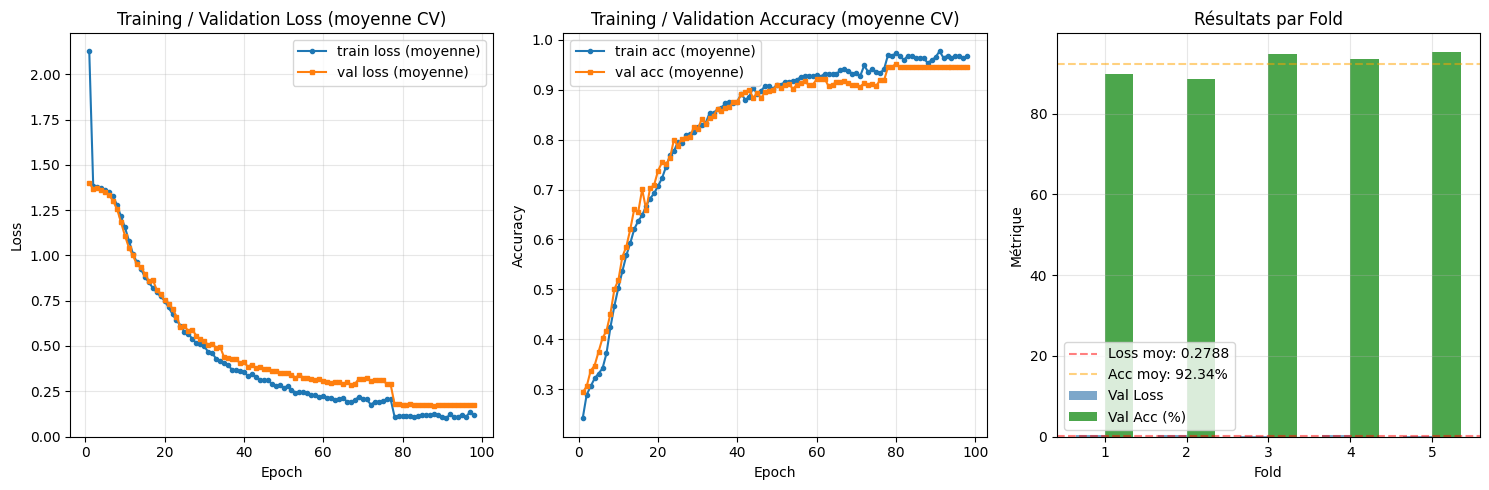

✅ Figures sauvegardées: loss_acc_curves_4_classes.png


In [8]:
# Visualisation des courbes moyennes
epochs = np.arange(1, len(history["train_loss"]) + 1)

# Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], label="train loss (moyenne)", marker='o', markersize=3)
plt.plot(epochs, history["val_loss"],   label="val loss (moyenne)", marker='s', markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss (moyenne CV)")
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_acc"], label="train acc (moyenne)", marker='o', markersize=3)
plt.plot(epochs, history["val_acc"],   label="val acc (moyenne)", marker='s', markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training / Validation Accuracy (moyenne CV)")
plt.legend()
plt.grid(True, alpha=0.3)

# Résultats par fold
plt.subplot(1, 3, 3)
x_pos = np.arange(len(cv_results['fold']))
width = 0.35
plt.bar(x_pos - width/2, cv_results['best_val_loss'], width, label='Val Loss', alpha=0.7, color='steelblue')
plt.bar(x_pos + width/2, [acc*100 for acc in cv_results['best_val_acc']], width, label='Val Acc (%)', alpha=0.7, color='green')
plt.axhline(np.mean(cv_results['best_val_loss']), color='red', linestyle='--', alpha=0.5, label=f'Loss moy: {np.mean(cv_results["best_val_loss"]):.4f}')
plt.axhline(np.mean(cv_results['best_val_acc'])*100, color='orange', linestyle='--', alpha=0.5, label=f'Acc moy: {np.mean(cv_results["best_val_acc"])*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Métrique')
plt.title('Résultats par Fold')
plt.xticks(x_pos, cv_results['fold'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("loss_acc_curves_4_classes.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figures sauvegardées: loss_acc_curves_4_classes.png")


## 6) Évaluation finale avec API moderne


In [9]:
from torch.amp import autocast

@torch.no_grad()
def evaluate_multiclass(model, loader, device, class_names):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    use_amp = (device.type == "cuda")
    dtype = torch.float16 if use_amp else torch.float32
    
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        # API moderne torch.amp
        if use_amp:
            with autocast(device_type='cuda', dtype=dtype):
                logits = model(xb)            # [B, num_classes]
        else:
            logits = model(xb)
        
        probs = torch.softmax(logits, dim=1).cpu().numpy()  # [B, num_classes]
        preds = logits.argmax(dim=1).cpu().numpy()  # [B]
        
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())

    y_true = np.concatenate(all_targets, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)
    y_prob = np.concatenate(all_probs, axis=0)

    acc = accuracy_score(y_true, y_pred)
    
    # Métriques pour classification multi-classe
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # AUC pour multi-classe (one-vs-rest)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    except:
        auc = None
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    
    return {
        "accuracy": acc,
        "precision_per_class": prec,
        "recall_per_class": rec,
        "f1_per_class": f1,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
        "auc": auc,
        "confusion_matrix": cm,
        "report": report,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

# Le meilleur modèle est déjà chargé depuis la cross-validation
checkpoint_path = "checkpoints/best_cnn_4_classes.pt"
if os.path.exists(checkpoint_path):
    best_ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    if "model" in best_ckpt:
        model.load_state_dict(best_ckpt["model"])
        class_names = best_ckpt.get("class_names", ds_tmp.classes)
        print(f"✅ Modèle chargé depuis le checkpoint (CV mean val_loss: {best_ckpt.get('cv_mean_val_loss', 'N/A'):.4f})\n")
    else:
        print("⚠️ Format de checkpoint différent. Utilisation du modèle actuel.\n")
        class_names = ds_tmp.classes
else:
    print("⚠️ Le checkpoint n'existe pas. Utilisation du modèle actuel.\n")
    class_names = ds_tmp.classes

# Évaluation sur le test set
metrics = evaluate_multiclass(model, test_loader, device, class_names)
print("=== Test metrics ===")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"\nMétriques par classe:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:25s}: Precision={metrics['precision_per_class'][i]:.4f}, "
          f"Recall={metrics['recall_per_class'][i]:.4f}, F1={metrics['f1_per_class'][i]:.4f}")
print(f"\nMétriques macro-moyennes:")
print(f"  Precision: {metrics['precision_macro']:.4f}")
print(f"  Recall   : {metrics['recall_macro']:.4f}")
print(f"  F1       : {metrics['f1_macro']:.4f}")
if metrics['auc'] is not None:
    print(f"  AUC     : {metrics['auc']:.4f}")
print("\nConfusion matrix:")
print(metrics["confusion_matrix"])
print("\n" + metrics["report"])


✅ Modèle chargé depuis le checkpoint (CV mean val_loss: 0.2788)

=== Test metrics ===
Accuracy : 0.9355

Métriques par classe:
  Abnormal_Heartbeat       : Precision=0.9545, Recall=0.9130, F1=0.9333
  History_MI               : Precision=1.0000, Recall=0.8235, F1=0.9032
  Myocardial_Infarction    : Precision=1.0000, Recall=1.0000, F1=1.0000
  Normal                   : Precision=0.8485, Recall=0.9655, F1=0.9032

Métriques macro-moyennes:
  Precision: 0.9508
  Recall   : 0.9255
  F1       : 0.9349

Confusion matrix:
[[21  0  0  2]
 [ 0 14  0  3]
 [ 0  0 24  0]
 [ 1  0  0 28]]

                       precision    recall  f1-score   support

   Abnormal_Heartbeat     0.9545    0.9130    0.9333        23
           History_MI     1.0000    0.8235    0.9032        17
Myocardial_Infarction     1.0000    1.0000    1.0000        24
               Normal     0.8485    0.9655    0.9032        29

             accuracy                         0.9355        93
            macro avg     0.9508    0

## 7) Analyse des erreurs de classification

Visualisation des images mal classées pour comprendre les limites du modèle.


Analyse des erreurs de classification:


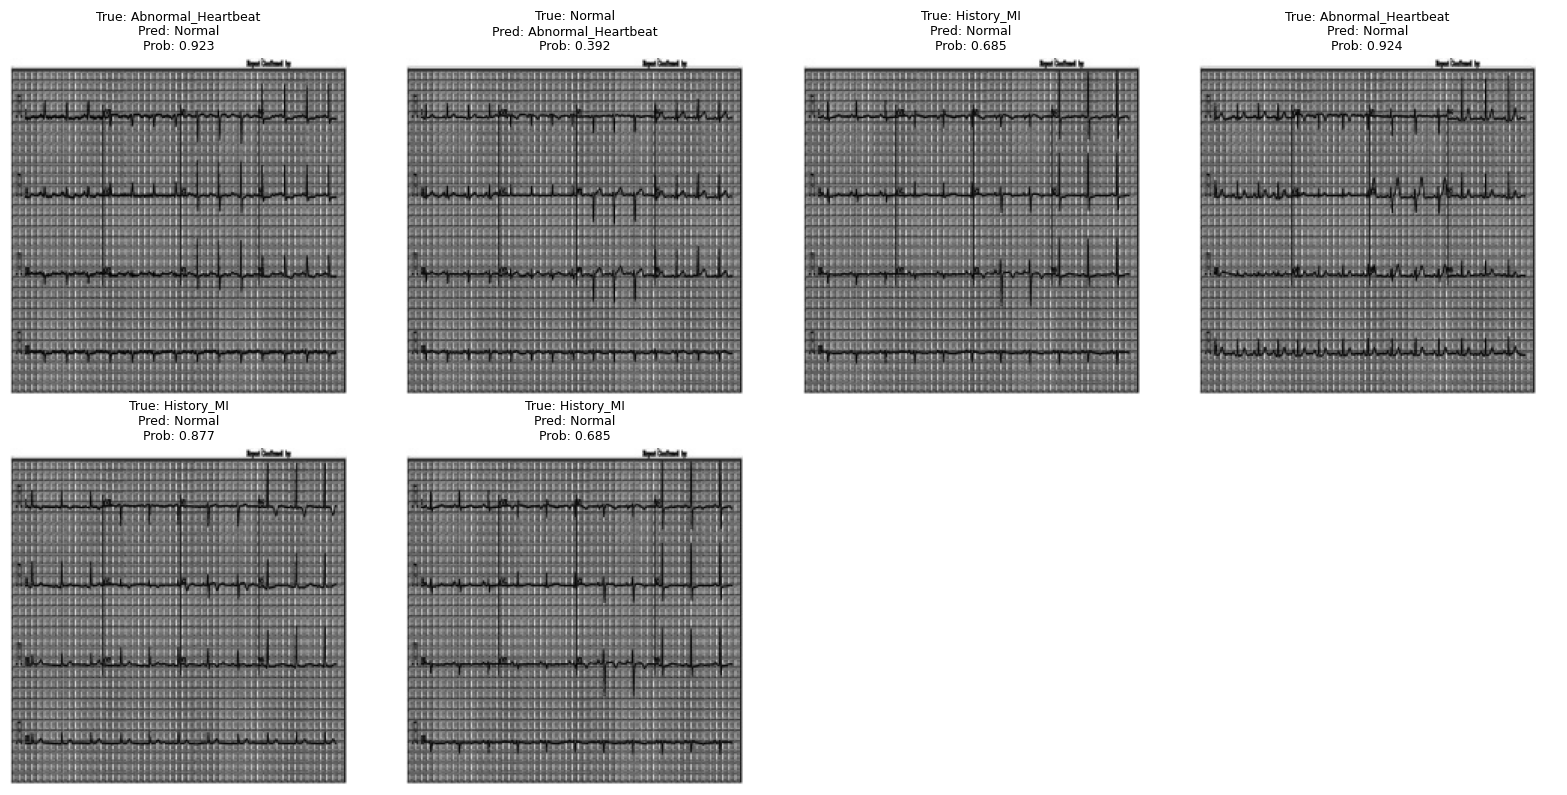


📊 Résumé des erreurs:
   - Total d'erreurs trouvées: 6

   Répartition des erreurs:
     History_MI → Normal: 3
     Abnormal_Heartbeat → Normal: 2
     Normal → Abnormal_Heartbeat: 1


In [10]:
def visualize_errors(model, loader, device, class_names, num_samples=12):
    """
    Visualise les images mal classées par le modèle (multi-classe)
    """
    model.eval()
    errors = []  # Liste des (image, vraie_label, prédiction, probabilité)
    
    use_amp = (device.type == "cuda")
    dtype = torch.float16 if use_amp else torch.float32
    
    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(loader):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            
            if use_amp:
                with autocast(device_type='cuda', dtype=dtype):
                    logits = model(xb)
            else:
                logits = model(xb)
            
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # Trouver les erreurs dans ce batch
            incorrect = (preds != yb).cpu().numpy()
            for i in range(len(incorrect)):
                if incorrect[i]:
                    # Récupérer l'image originale (dénormalisée)
                    img = xb[i].cpu()
                    # Dénormaliser pour visualisation
                    img_denorm = img * torch.tensor(STD).view(1,1,1) + torch.tensor(MEAN).view(1,1,1)
                    img_denorm = torch.clamp(img_denorm, 0, 1)
                    
                    errors.append({
                        'image': img_denorm.squeeze(0),
                        'true_label': yb[i].item(),
                        'pred_label': preds[i].item(),
                        'probability': probs[i].max().item(),
                        'prob_dist': probs[i].cpu().numpy()
                    })
            
            if len(errors) >= num_samples:
                break
    
    if len(errors) == 0:
        print("✅ Aucune erreur trouvée ! Le modèle a une précision parfaite sur cet ensemble.")
        return
    
    # Afficher les erreurs
    num_to_show = min(num_samples, len(errors))
    cols = 4
    rows = (num_to_show + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if num_to_show > 1 else [axes]
    axes = axes.flatten()
    
    for idx in range(num_to_show):
        error = errors[idx]
        ax = axes[idx]
        
        ax.imshow(error['image'], cmap='gray')
        true_class = class_names[error['true_label']]
        pred_class = class_names[error['pred_label']]
        prob = error['probability']
        
        title = f"True: {true_class}\nPred: {pred_class}\nProb: {prob:.3f}"
        ax.set_title(title, fontsize=9)
        ax.axis('off')
    
    # Masquer les axes inutilisés
    for idx in range(num_to_show, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig("classification_errors_4_classes.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Résumé des erreurs:")
    print(f"   - Total d'erreurs trouvées: {len(errors)}")
    
    # Statistiques par type d'erreur
    error_matrix = {}
    for e in errors:
        true_class = class_names[e['true_label']]
        pred_class = class_names[e['pred_label']]
        key = f"{true_class} → {pred_class}"
        error_matrix[key] = error_matrix.get(key, 0) + 1
    
    print(f"\n   Répartition des erreurs:")
    for error_type, count in sorted(error_matrix.items(), key=lambda x: x[1], reverse=True):
        print(f"     {error_type}: {count}")

# Visualiser les erreurs (si il y en a)
print("="*50)
print("Analyse des erreurs de classification:")
print("="*50)
visualize_errors(model, test_loader, device, class_names, num_samples=12)


## 8) Visualisation détaillée des résultats de Cross-Validation

**Résumé des résultats de la validation croisée :**
- ✅ Tous les folds ont été entraînés avec early stopping
- ✅ Le meilleur modèle global a été sélectionné
- ✅ Évaluation finale sur le test set séparé


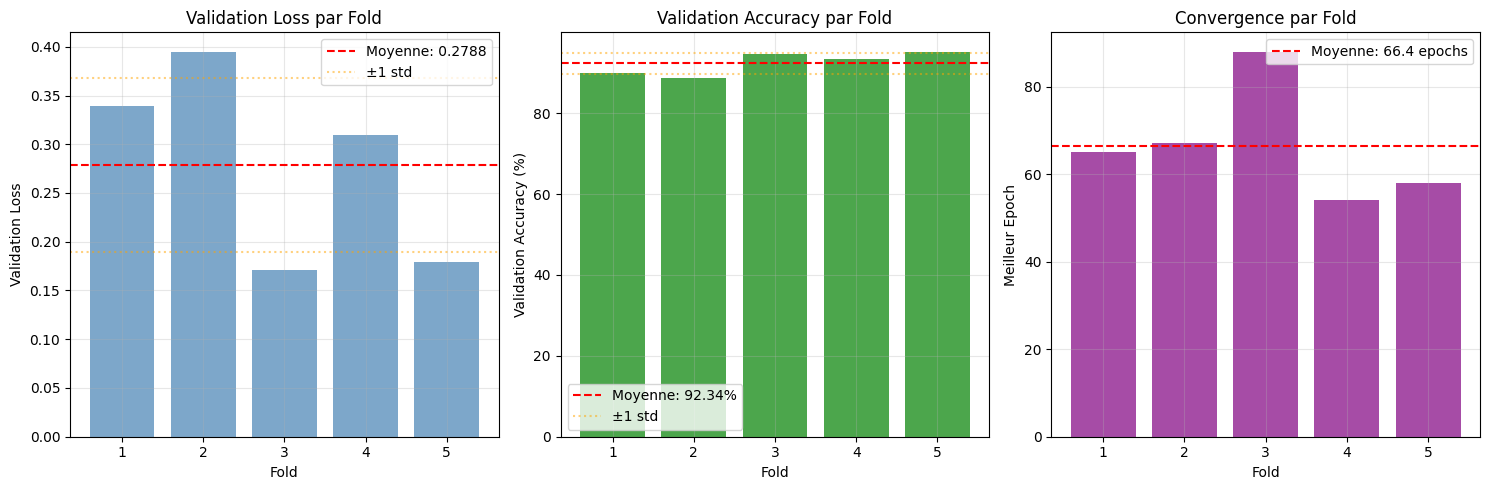

✅ Graphiques détaillés sauvegardés: cross_validation_results_4_classes.png


In [11]:
# Visualisation détaillée des résultats de cross-validation
plt.figure(figsize=(15, 5))

# 1. Validation Loss par fold
plt.subplot(1, 3, 1)
plt.bar(cv_results['fold'], cv_results['best_val_loss'], alpha=0.7, color='steelblue')
plt.axhline(np.mean(cv_results['best_val_loss']), color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(cv_results["best_val_loss"]):.4f}')
plt.axhline(np.mean(cv_results['best_val_loss']) + np.std(cv_results['best_val_loss']), 
            color='orange', linestyle=':', alpha=0.5, label='±1 std')
plt.axhline(np.mean(cv_results['best_val_loss']) - np.std(cv_results['best_val_loss']), 
            color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.title('Validation Loss par Fold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Validation Accuracy par fold
plt.subplot(1, 3, 2)
plt.bar(cv_results['fold'], [acc*100 for acc in cv_results['best_val_acc']], alpha=0.7, color='green')
plt.axhline(np.mean(cv_results['best_val_acc'])*100, color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(cv_results["best_val_acc"])*100:.2f}%')
plt.axhline((np.mean(cv_results['best_val_acc']) + np.std(cv_results['best_val_acc']))*100, 
            color='orange', linestyle=':', alpha=0.5, label='±1 std')
plt.axhline((np.mean(cv_results['best_val_acc']) - np.std(cv_results['best_val_acc']))*100, 
            color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy par Fold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Epochs par fold (pour voir la convergence)
plt.subplot(1, 3, 3)
plt.bar(cv_results['fold'], cv_results['best_epoch'], alpha=0.7, color='purple')
plt.axhline(np.mean(cv_results['best_epoch']), color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(cv_results["best_epoch"]):.1f} epochs')
plt.xlabel('Fold')
plt.ylabel('Meilleur Epoch')
plt.title('Convergence par Fold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cross_validation_results_4_classes.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Graphiques détaillés sauvegardés: cross_validation_results_4_classes.png")


## 9) Matrice de confusion détaillée

Visualisation de la matrice de confusion avec les noms des classes.


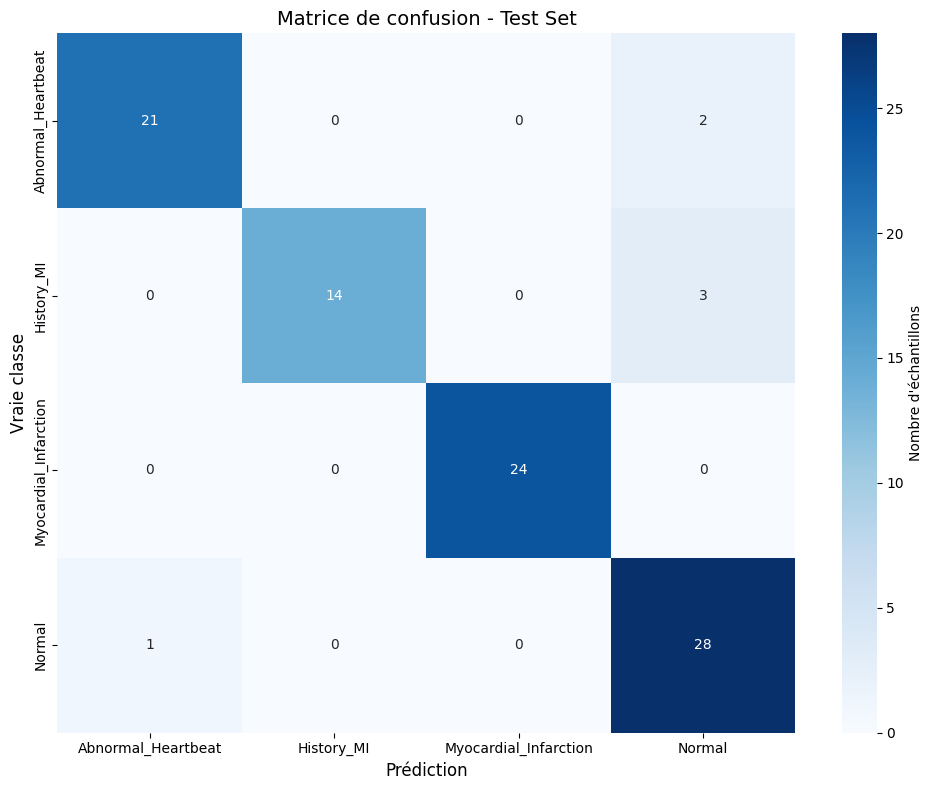

✅ Matrice de confusion sauvegardée: confusion_matrix_4_classes.png


In [12]:
# Visualisation de la matrice de confusion
import seaborn as sns

cm = metrics['confusion_matrix']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre d\'échantillons'})
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Vraie classe', fontsize=12)
plt.title('Matrice de confusion - Test Set', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_4_classes.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Matrice de confusion sauvegardée: confusion_matrix_4_classes.png")
